In [1]:
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import os
import glob
import os.path as path
from tqdm import tqdm ,trange
import shutil
import pickle
# only for text to speeh
import pyttsx3

In [2]:
sampling_freq, audio = wavfile.read("Data/InsectSoundOriginal/Aedes_female/120502_f0028_m0407.80.wav")
mfcc_features = mfcc(audio, sampling_freq ,nfft=551)
filterbank_features = logfbank(audio, sampling_freq)

In [3]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 98
Length of each feature = 13

Filter bank:
Number of windows = 98
Length of each feature = 26


10
Data/InsectSoundOriginal/Aedes_female\120501_f0002_m1096.83.wav 98
Data/InsectSoundOriginal/Aedes_male\120501_f0002_m1104.88.wav 98
Data/InsectSoundOriginal/Fruit_flies\120425_f0002_m1095.20.wav 98
Data/InsectSoundOriginal/House_flies\120521_f0002_m0968.15.wav 98
Data/InsectSoundOriginal/Quinx_female\120502_f0055_m1147.69.wav 98
Data/InsectSoundOriginal/Quinx_male\120425_f0008_m1317.92.wav 98
Data/InsectSoundOriginal/Stigma_female\100816_f0009_m1309.43.wav 98
Data/InsectSoundOriginal/Stigma_male\120615_f0010_m1242.36.wav 98
Data/InsectSoundOriginal/Tarsalis_female\120501_f0002_m1099.42.wav 98
Data/InsectSoundOriginal/Tarsalis_male\120501_f0003_m1146.51.wav 98


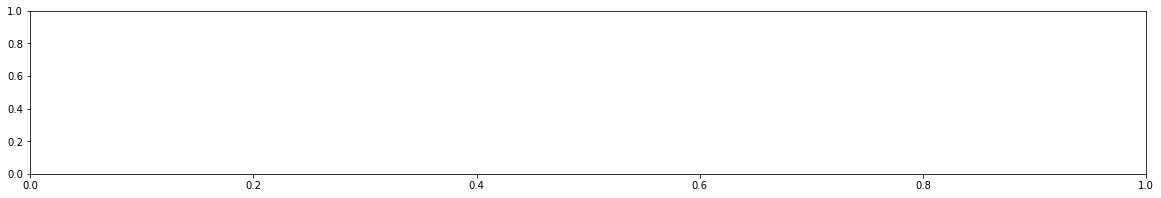

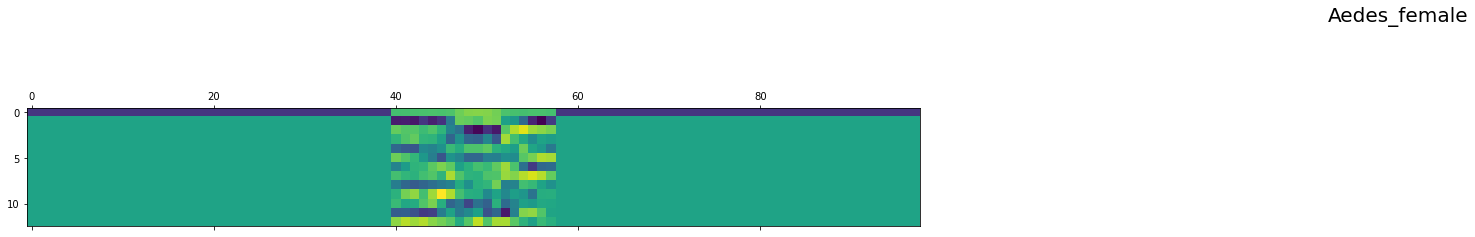

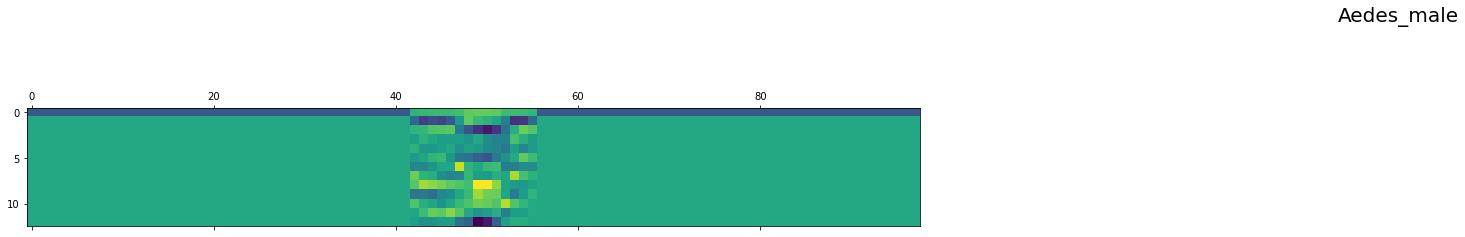

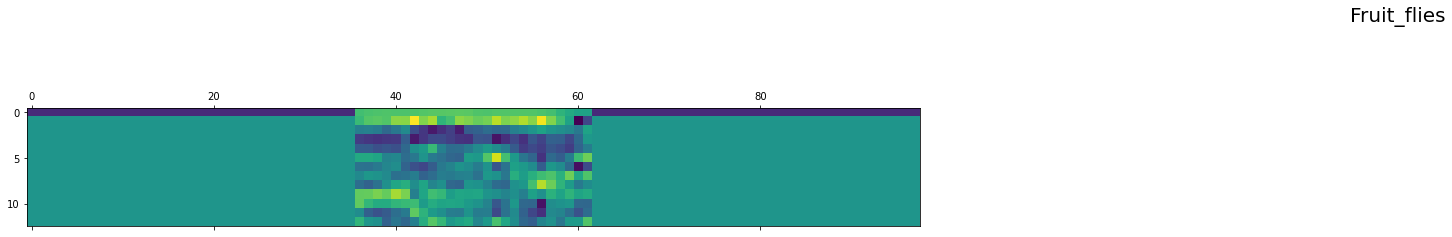

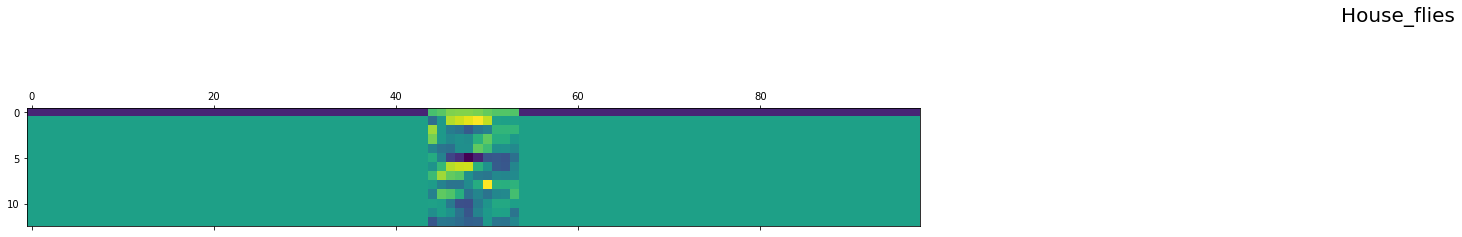

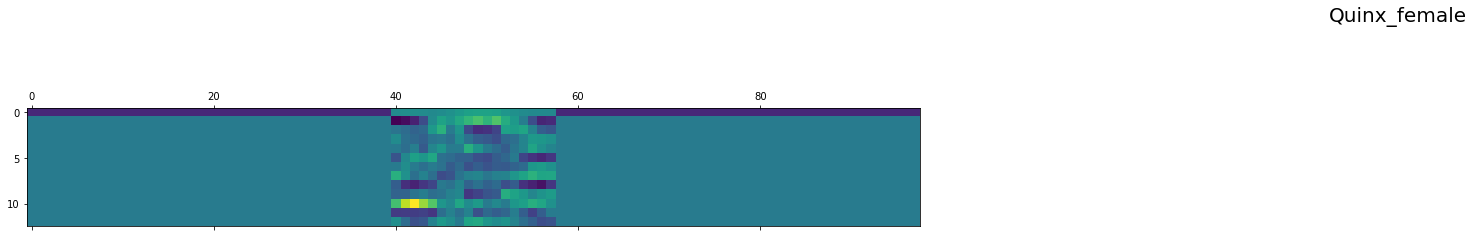

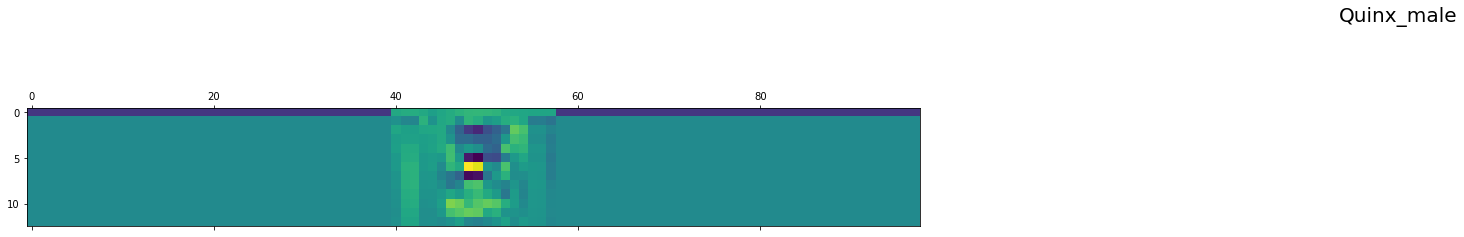

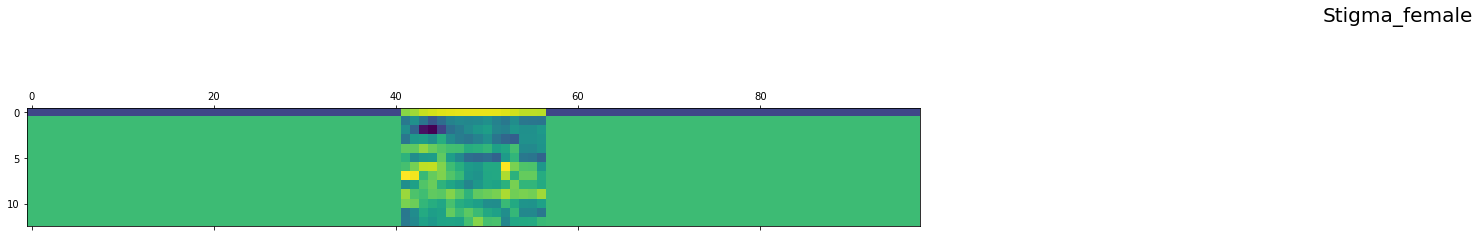

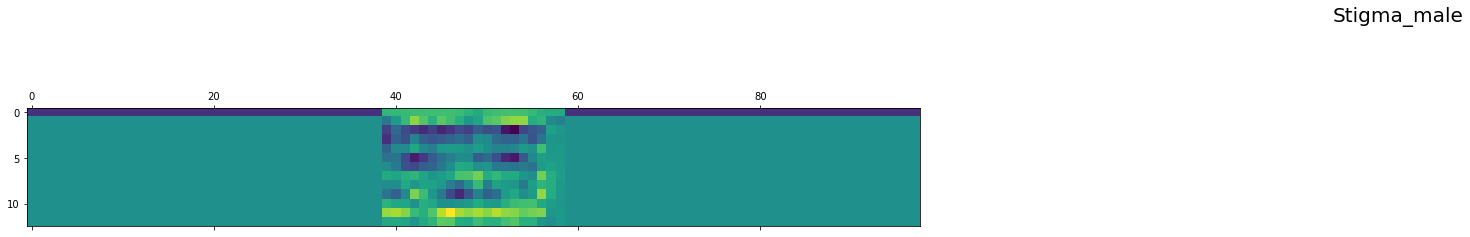

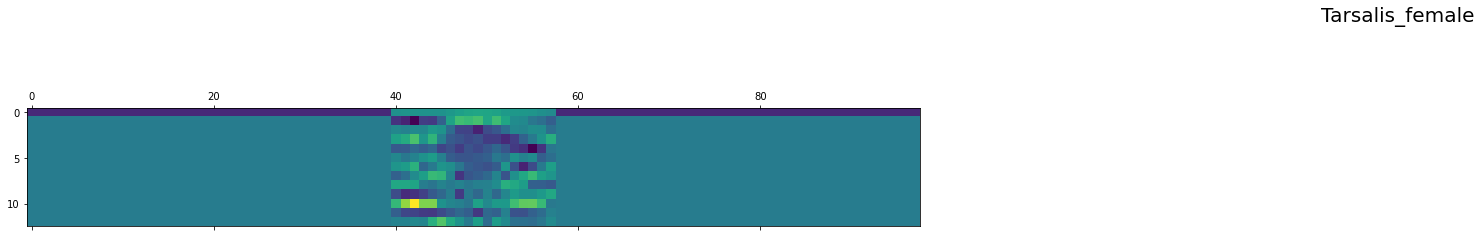

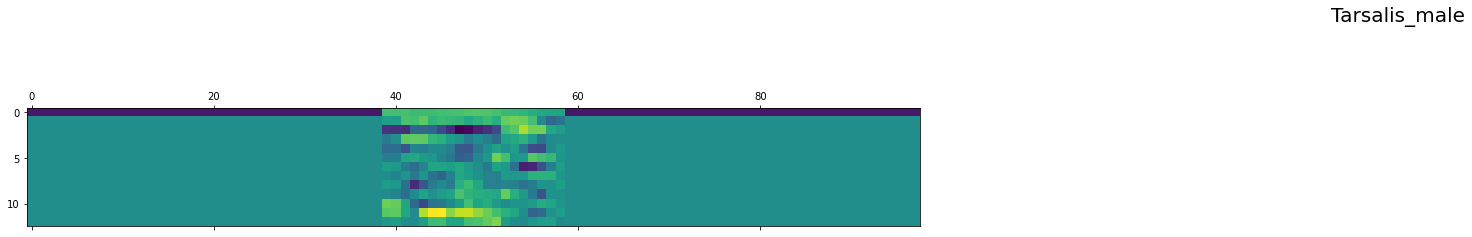

In [4]:
Classes = ['Aedes_female','Aedes_male','Fruit_flies','House_flies','Quinx_female','Quinx_male','Stigma_female','Stigma_male','Tarsalis_female','Tarsalis_male']
print(len(Classes))
figure = plt.figure(figsize=(20,3))
for idx ,insect in enumerate(Classes): 
    example_data_path = 'Data/InsectSoundOriginal/' + insect
    file_paths = glob.glob(path.join(example_data_path, '*.wav'))
    sampling_freq, audio = wavfile.read(file_paths[0])
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    print(file_paths[0], mfcc_features.shape[0])
    plt.yscale('linear')
    plt.matshow((mfcc_features.T)[:,:300])
    plt.text(150, -10, insect, horizontalalignment='center', fontsize=20)
plt.yscale('linear')
plt.show()

In [5]:
class HMMTrainer(object):
    def __init__(self, model_name,n_components,cov_type,algorithm,n_iter,verbose=False):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.algorithm=algorithm
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type,algorithm = self.algorithm,n_iter=self.n_iter)
        elif self.model_name == 'GaussianMixEm':
            self.model = hmm.GMMHMM(n_components=self.n_components,covariance_type=self.cov_type,algorithm = self.algorithm,n_iter=self.n_iter)
        elif self.model_name == 'MultinomialHMM':
            self.model = hmm.MultinomialHMM(n_components=self.n_components,algorithm = self.algorithm,n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type') 
    def train(self, X):
        print('Working on HMM Model',self.model_name)
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))
    
    #def decode(self,X):
    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [6]:
def HMMtraningModelInit(modelName,nComponents,covarianceType,algorithmName,iterarionNum):
    hmm_models = []
    input_folder = 'Data/InsectSoundOriginal/'
    # Parse the input directory
    for dirname in os.listdir(input_folder):
        # Get the name of the subfolder
        subfolder = os.path.join(input_folder, dirname)
        if not os.path.isdir(subfolder):
            continue
        # Extract the label
        label = subfolder[subfolder.rfind('/') + 1:]
        # Initialize variables
        X = np.array([])
        y_words = []
        i = 0
        # Iterate through the audio files (leaving 1 file for testing in each class)
        print('Traning Files : ', label)
        for filename in tqdm([x for x in os.listdir(subfolder) if x.endswith('.wav')][:4000]):
                # Read the input file
                filepath = os.path.join(subfolder, filename)
                sampling_freq, audio = wavfile.read(filepath)
                # Extract MFCC features
                mfcc_features = mfcc(audio, sampling_freq)
                # Append to the variable X
                if len(X) == 0:
                    X = mfcc_features
                else:
                    X = np.append(X, mfcc_features, axis=0)
                # Append the label
                y_words.append(label)
        print('X.shape =', X.shape)
        # Train and save HMM model
        hmm_trainer = HMMTrainer(model_name=modelName,n_components=nComponents,cov_type=covarianceType,algorithm=algorithmName,n_iter=iterarionNum)
        hmm_trainer.train(X)
        hmm_models.append((hmm_trainer, label))
        hmm_trainer = None
    return hmm_models

In [7]:
hmm_models = HMMtraningModelInit('GaussianHMM',10,'diag','viterbi',100)
#hmm_models = HMMtraningModelInit('GaussianHMM',10,'full','viterbi',10)
#hmm_models = HMMtraningModelInit('GaussianMixEm',10,'full','viterbi',10)

  1%|          | 31/4000 [00:00<00:12, 307.09it/s]

Traning Files :  Aedes_female


100%|██████████| 4000/4000 [00:47<00:00, 83.44it/s] 


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  1%|          | 29/4000 [00:00<00:13, 287.29it/s]

Traning Files :  Aedes_male


100%|██████████| 4000/4000 [00:49<00:00, 81.17it/s] 


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  0%|          | 18/4000 [00:00<00:26, 151.34it/s]

Traning Files :  Fruit_flies


100%|██████████| 4000/4000 [01:11<00:00, 56.25it/s]


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  1%|          | 22/4000 [00:00<00:18, 211.66it/s]

Traning Files :  House_flies


100%|██████████| 4000/4000 [01:07<00:00, 59.14it/s]


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  1%|          | 30/4000 [00:00<00:13, 291.43it/s]

Traning Files :  Quinx_female


100%|██████████| 4000/4000 [00:53<00:00, 74.17it/s] 


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  1%|          | 31/4000 [00:00<00:13, 304.00it/s]

Traning Files :  Quinx_male


100%|██████████| 4000/4000 [00:49<00:00, 80.69it/s] 


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  1%|          | 30/4000 [00:00<00:13, 297.20it/s]

Traning Files :  Stigma_female


100%|██████████| 4000/4000 [01:55<00:00, 34.72it/s]


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  0%|          | 12/4000 [00:00<00:36, 110.15it/s]

Traning Files :  Stigma_male


100%|██████████| 4000/4000 [02:16<00:00, 29.26it/s]


X.shape = (392000, 13)
Working on HMM Model GaussianHMM
Traning Files :  Tarsalis_female


100%|██████████| 4000/4000 [01:47<00:00, 37.36it/s]


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


  0%|          | 0/4000 [00:00<?, ?it/s]

Traning Files :  Tarsalis_male


100%|██████████| 4000/4000 [01:44<00:00, 38.44it/s]


X.shape = (392000, 13)
Working on HMM Model GaussianHMM


In [8]:
with open('Models/hmm_models_insectSound_GaussianHMM_diag_100.pkl', 'wb') as fid:
    pickle.dump(hmm_models, fid)

In [9]:
with open('Models/hmm_models_insectSound_GaussianHMM_diag_100.pkl', 'rb') as f:
    hmm_models_new = pickle.load(f)

In [10]:
def makeTestFiles(numofFile):
    for dirname2 in tqdm(os.listdir('Data/InsectSoundOriginal/')):
        subfolder2 = os.path.join('Data/InsectSoundOriginal/', dirname2)
        print(subfolder2.split('/')[2])
        for filename2 in [x for x in os.listdir(subfolder2) if x.endswith('.wav')][-int(numofFile):]:
            filepath2 = os.path.join(subfolder2, filename2)
            newDir = 'Data/InsectTest/'+subfolder2.split('/')[2]+'/'
            try:
                os.mkdir(newDir)
            except:
                shutil.copy(filepath2,newDir)

In [11]:
# makeTestFiles(1000)

  0%|          | 0/10 [00:00<?, ?it/s]

Aedes_female


 10%|█         | 1/10 [00:09<01:29,  9.97s/it]

Aedes_male


 20%|██        | 2/10 [00:19<01:18,  9.85s/it]

Fruit_flies


 30%|███       | 3/10 [00:29<01:09,  9.90s/it]

House_flies


 40%|████      | 4/10 [00:39<00:59,  9.92s/it]

Quinx_female


 50%|█████     | 5/10 [00:49<00:49,  9.92s/it]

Quinx_male


 60%|██████    | 6/10 [00:59<00:39,  9.86s/it]

Stigma_female


 70%|███████   | 7/10 [01:09<00:29,  9.85s/it]

Stigma_male


 80%|████████  | 8/10 [01:18<00:19,  9.83s/it]

Tarsalis_female


 90%|█████████ | 9/10 [01:28<00:09,  9.79s/it]

Tarsalis_male


100%|██████████| 10/10 [01:38<00:00,  9.82s/it]


In [12]:
input_folder = 'Data/InsectTest/'
real_labels = []
pred_labels = []
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder):
        continue
  # Extract the label
    label_real = subfolder[subfolder.rfind('/') + 1:]
    for filename in tqdm([x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]):
        real_labels.append(label_real)
        filepath = os.path.join(subfolder, filename)
        sampling_freq, audio = wavfile.read(filepath)
        mfcc_features = mfcc(audio, sampling_freq)
        max_score = -10**100
        output_label = None
        for item in hmm_models_new:
            hmm_model, label = item
            score = hmm_model.get_score(mfcc_features)
            if score > max_score:
                max_score = score
                output_label = label
        pred_labels.append(output_label)

100%|██████████| 999/999 [00:16<00:00, 59.27it/s]


In [13]:
print(len(real_labels),len(pred_labels))

9990 9990


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.272 0.008 0.012 0.104 0.241 0.    0.272 0.082 0.002 0.006]
 [0.    0.782 0.001 0.043 0.    0.12  0.011 0.018 0.    0.025]
 [0.007 0.    0.254 0.447 0.02  0.001 0.245 0.015 0.006 0.004]
 [0.    0.    0.006 0.93  0.    0.002 0.056 0.001 0.005 0.   ]
 [0.043 0.007 0.008 0.111 0.271 0.    0.525 0.029 0.005 0.001]
 [0.    0.084 0.001 0.136 0.    0.459 0.037 0.136 0.    0.146]
 [0.084 0.005 0.035 0.218 0.152 0.    0.482 0.015 0.006 0.002]
 [0.007 0.    0.006 0.095 0.001 0.003 0.05  0.791 0.    0.047]
 [0.004 0.    0.033 0.641 0.01  0.003 0.128 0.046 0.129 0.006]
 [0.001 0.07  0.002 0.114 0.    0.316 0.022 0.169 0.    0.305]]


<Figure size 432x288 with 0 Axes>

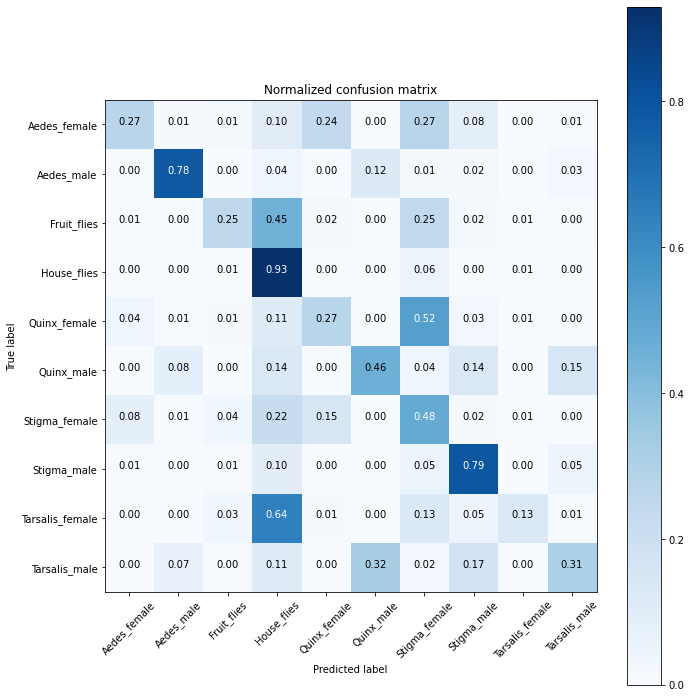

In [15]:
cm = confusion_matrix(real_labels, pred_labels)
np.set_printoptions(precision=3)
classes = ['Aedes_female','Aedes_male','Fruit_flies','House_flies','Quinx_female','Quinx_male','Stigma_female','Stigma_male','Tarsalis_female','Tarsalis_male']
plt.figure()
plot_confusion_matrix(cm, classes=classes, normalize=True,title='Normalized confusion matrix')
plt.show()

In [16]:
classes = ['Aedes_female','Aedes_male','Fruit_flies','House_flies','Quinx_female','Quinx_male','Stigma_female','Stigma_male','Tarsalis_female','Tarsalis_male']
print(classification_report(real_labels, pred_labels, target_names=classes))

                 precision    recall  f1-score   support

   Aedes_female       0.65      0.27      0.38       999
     Aedes_male       0.82      0.78      0.80       999
    Fruit_flies       0.71      0.25      0.37       999
    House_flies       0.33      0.93      0.48       999
   Quinx_female       0.39      0.27      0.32       999
     Quinx_male       0.51      0.46      0.48       999
  Stigma_female       0.26      0.48      0.34       999
    Stigma_male       0.61      0.79      0.69       999
Tarsalis_female       0.84      0.13      0.22       999
  Tarsalis_male       0.56      0.31      0.40       999

       accuracy                           0.47      9990
      macro avg       0.57      0.47      0.45      9990
   weighted avg       0.57      0.47      0.45      9990

